In [1]:
from sympy import *
init_printing()
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline

The variance of the bare force diverges in the Monte Carlo integral.

In [2]:
r = Symbol('r',positive=True)
V = 1/r
F = - diff(V, r)

In [3]:
F

In [35]:
epos = np.array([[0.0, 1.0, 0.0],
                 [0.2, 0.3, 0.0]])
npos = np.array([[0.0, 0.0, .0]])

In [36]:
def compute_bare_force(npos, epos, F, r):
    forces = np.zeros_like(npos)
    for ion_idx,ion_pos in enumerate(npos):   
        for elec in epos:
            dr = elec - ion_pos
            dr2 = np.dot(dr,dr)
            dr_norm = np.sqrt(dr2)
            #print dr_norm
            dr_hat = dr/dr_norm
            force_component = float(F.subs(r, dr_norm))
            #print dr_norm, 1.0/dr_norm, force_component
            forces[ion_idx] += force_component*dr_hat
            #print ''
    return forces

In [37]:
forces = compute_bare_force(npos, epos, F, r)
print forces

[[ 4.26692459  7.40038688  0.        ]]


One solution is to smooth the contribution inside some cutoff radius $R_c$.
See Chiesa, Ceperley, and Zhang (PRL 94, 036404 (2005))

In [8]:
M = Symbol('M', integer=True)
k = Symbol('k', integer=True,positive=True)
a = IndexedBase('a',(M,))
Rc = Symbol('R_c', positive=True)

The goal is to fit a constant function with a polynomial that is missing the constant term (only powers of $r$ with $k\gt 0$)

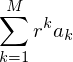

In [9]:
# Equation 4 in the paper
fbar = Sum(a[k]*r**k, (k,1,M))
fbar

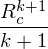

In [46]:
# Integrate individual terms
integrate(r**k,(r,0,Rc)).doit()

In [47]:
# Still need to get to equations 6-8 from equations 2-4

In [11]:
m = Symbol('m')
c = IndexedBase('c',(M,))
j = Symbol('j',integer=True)

Matrix and vector that define the coefficients, equation 8 in the paper:

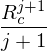

In [44]:
Skj = Rc**(m+k+j+1)/(m+k+j+1)
hj = Rc**(j+1)/(j+1)
hj

In [13]:
grfits = OrderedDict()

In [14]:
Mval = 4
mval = 2
S = np.zeros((Mval,Mval))
h = np.zeros(Mval)
Rcval = 0.4
for kval in range(Mval):
    for jval in range(Mval):
        S[kval,jval] = Skj.subs({M:Mval,m:mval,k:kval+1,j:jval+1,Rc:Rcval})
for jval in range(Mval):
    h[jval] = hj.subs({j:jval+1, Rc:Rcval})
print S
print h

[[  2.04800000e-03   6.82666667e-04   2.34057143e-04   8.19200000e-05]
 [  6.82666667e-04   2.34057143e-04   8.19200000e-05   2.91271111e-05]
 [  2.34057143e-04   8.19200000e-05   2.91271111e-05   1.04857600e-05]
 [  8.19200000e-05   2.91271111e-05   1.04857600e-05   3.81300364e-06]]
[ 0.08        0.02133333  0.0064      0.002048  ]


In [15]:
ck = np.linalg.solve(S,h)
ck

array([   4375.00000011,  -44296.87500127,  147656.25000466,
       -161132.81250545])

In [16]:
# Dump in C++ format for inclusion in the unit test
print '// for m_exp=%d, N_basis=%d, Rcut=%f'%(mval, Mval, Rcval)
print 'coeff[%d] = {'%len(ck),
print ','.join(['%g'%ck1 for ck1 in ck]),
#for c in ck:
#    print '%g,'%c,
print '};'

// for m_exp=2, N_basis=4, Rcut=0.400000
coeff[4] = { 4375,-44296.9,147656,-161133 };


In [17]:
np.dot(np.linalg.inv(S),h)

array([   4375.00000011,  -44296.87500127,  147656.25000465,
       -161132.81250544])

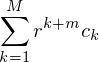

In [18]:
gr = Sum(c[k]*r**(k+m),(k,1,M))
gr

In [19]:
gr2 = gr.subs({M:Mval, m:mval}).doit()

cc = c.subs(M,Mval)
print 'gr2 = ',gr2
for kval in range(Mval):
    print kval, c[kval+1],ck[kval]
    gr2 = gr2.subs(cc[kval+1],ck[kval])
    print kval,gr2
gr2
grfits[Mval] = gr2

gr2 =  r**6*c[4] + r**5*c[3] + r**4*c[2] + r**3*c[1]
0 c[1] 4375.00000011
0 r**6*c[4] + r**5*c[3] + r**4*c[2] + 4375.00000010899*r**3
1 c[2] -44296.8750013
1 r**6*c[4] + r**5*c[3] - 44296.8750012704*r**4 + 4375.00000010899*r**3
2 c[3] 147656.250005
2 r**6*c[4] + 147656.250004658*r**5 - 44296.8750012704*r**4 + 4375.00000010899*r**3
3 c[4] -161132.812505
3 -161132.812505447*r**6 + 147656.250004658*r**5 - 44296.8750012704*r**4 + 4375.00000010899*r**3


In [39]:
def compute_smoothed_force(npos, epos, F, r):
    forces = np.zeros_like(npos)
    for ion_idx,ion_pos in enumerate(npos):   
        for elec in epos:
            dr = elec - ion_pos
            dr2 = np.dot(dr,dr)
            dr_norm = np.sqrt(dr2)
            #print dr_norm
            dr_hat = dr/dr_norm
            #print 'dr_norm',dr_norm
            if dr_norm < Rcval:
                force_component = float(gr2.subs(r, dr_norm)/dr2)
            else:
                force_component = float(F.subs(r, dr_norm))
            #print dr_norm, 1.0/dr_norm, force_component
            forces[ion_idx] += force_component*dr_hat
            #print ''
    return forces

In [40]:
print 'bare =',compute_bare_force(npos, epos, F, r)
forces = compute_smoothed_force(npos, epos, F, r)
print 'smoothed =',forces

bare = [[ 4.26692459  7.40038688  0.        ]]
smoothed = [[  9.24061106  14.86091659   0.        ]]


In [22]:
xss = OrderedDict()
yss = OrderedDict()
xs = []
ys = []
step = Rcval/50
for i in range(50):
    rval = i*step + step
    xs.append(rval)
    ys.append(exp(-rval**2))
#xss[0] = xs
#yss[0] = ys
for Mval,gr2 in grfits.iteritems():
    xs = []
    ys = []
    for i in range(50):
        rval = i*step + step
        #print rval, gr2.subs(r,rval)
        xs.append(rval)
        #ys.append(exp(-rval**2)*gr2.subs(r,rval))
        ys.append(gr2.subs(r,rval))
    xss[Mval] = xs
    yss[Mval] = ys

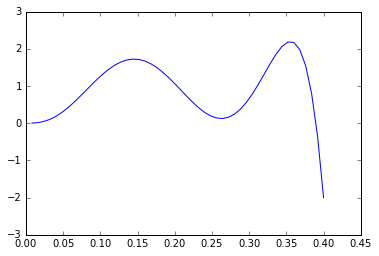

In [23]:

for Mval in xss.keys()[0:1]:
    plt.plot(xss[Mval],yss[Mval])
plt.show()

In [24]:
fx = lambda rval: exp(-rval**2)
print 0,mpmath.quad(fx, [0,Rcval])
for Mval, gr2 in grfits.iteritems():
    #fx = lambda rval : exp(-rval**2)*gr2.subs(r, rval)
    fx = lambda rval : gr2.subs(r,rval)
    ival = mpmath.quad(fx, [0,Rcval])
    #ival = integrate(exp(-r**2)*gr2/r**2,(r,0,Rcval))
    print Mval,ival

0 0.379652839700475
4 0.365714285715105
